# Supervised learning (Misleading Accuracies)

In this notebook we focus on how accuracy measures in **supervised learning** can be misleading.  **Supervised learning** is a set of algorithms that take **labeled** data and try to **predict** the label using the other **features** in the data. Supervised learning so far dominates applications of machine learning, although **reinforcement learning** is catching up too. Unlike **un-supervised learning** where the data is not labeled and hence there's a lot of subjectivity, **supervised learning** algorithms, once trained on data, can be evaluated by comparing their **predictions** to the **labels** (in this context, we refer to the labels sometimes as **ground truth**).  Sometimes these comparisons can be misleading.

As usual, let's begin by reading some data. We use a bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campain. The target `y` is binary and indicates whether the client signed up for a term deposit or not.

You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
bank = pd.read_csv("../../data/bank-full.csv", sep = ";").sample(5000)
print(bank.shape)
bank.head()

(5000, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
33875,35,admin.,single,tertiary,no,62,no,yes,cellular,30,apr,67,1,-1,0,unknown,no
5602,34,blue-collar,married,unknown,no,391,yes,yes,unknown,23,may,34,2,-1,0,unknown,no
6083,51,blue-collar,married,primary,no,51,no,no,unknown,27,may,121,2,-1,0,unknown,no
7855,33,technician,single,secondary,no,268,yes,no,unknown,30,may,275,9,-1,0,unknown,no
31720,39,blue-collar,single,primary,no,581,yes,no,cellular,7,apr,620,1,39,2,success,no


Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [16]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print("Numeric columns are {}.".format(", ".join(num_cols)))
print("Categorical columns are {}.".format(", ".join(cat_cols)))

Numeric columns are age, balance, day, duration, campaign, pdays, previous.
Categorical columns are job, marital, education, default, housing, loan, contact, month, poutcome.


As usual before we can proceed to machine learning, we need to get the data ready. And since we're doing supervised learning, we need to set aside test data so we can later evaluate the model using that data. So let's begin by splitting the data.

In [17]:
from sklearn.model_selection import train_test_split

X = bank.drop(columns = "y") # features
y = bank["y"] # label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [18]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [19]:
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")

Training data has 4250 rows.
Test data has 750 rows.


Before we begin our journey of trying out different algorithms in `sklearn` we do need to encode our categorical features.

In [20]:
from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse_output = False, drop = "first")
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names_out(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

Some algorithms we're going to use (such as decision tree) won't require that we normalize our numeric features, but most will. Not doing so won't break the algorithm, but just as we saw in the case of k-means, it will skew the results. So let's Z-normalize our numeric features now.

Pay attention that the normalizer is fitted on the training data, and used both on train and test data. This is the correct approach.

In [21]:
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)
X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,0.291338,-0.409263,-0.816121,1.706030,1.024337,-0.406004,-0.299845
1,-1.218529,-0.470143,1.816890,-0.594666,0.705754,-0.406004,-0.299845
2,0.102604,0.504631,-1.653897,-0.039888,-0.568576,-0.406004,-0.299845
3,-1.312895,-0.268022,-1.534214,1.269551,-0.249994,-0.406004,-0.299845
4,0.102604,-0.280546,0.380702,1.008479,-0.249994,-0.406004,-0.299845


We now join our numeric features and our one-hot-encoded categorical features into one data set, called `X_train_featurized`, that we pass to the decision tree classifier.

In [22]:
# Join the columns
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

# Alternate method to join columns:
# X2_train_featurized = pd.concat([X_train_onehot, X_train_norm], axis = 1)
# X2_test_featurized = pd.concat([X_test_onehot, X_test_norm], axis = 1)

# We delete objects so that we do not accidently use them
del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 4250 rows and 42 columns.
Featurized test data has 750 rows and 42 columns.


#### Decision tree classifier

With our data ready, we can now train a decision tree classifier. There is a lot of detail that we leave for another time, but in this lesson we want you to see the common pattern to all or most supervised learning algorithms: 

1. We create an **instance** of the algorithm, along with any settings we want to use. Here we instantiate a `DecisionTreeClassifier` and specify `max_depth = 3`.
1. We train the algorithm on the training data by calling the `fit` method.
1. Once the model is trained, we obtain prediction by calling the `predict` method. This method is similar to the  `transform` method for the pre-processing examples we saw in prior lessons, in that you give it a data, and it uses the trained model to run predictions on the data. We want predictions for both the training and test data, so we call `predict` twice. 

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [24]:

# dtree = DecisionTreeClassifier(max_depth = 3)
dtree = DecisionTreeClassifier(max_depth = 2)
dtree.fit(X_train_featurized, y_train)

y_hat_train = dtree.predict(X_train_featurized)
y_hat_test = dtree.predict(X_test_featurized)

Usually we are only interested in evaluating the model on the test data. But when we have many models we are comparing, it's useful to evaluate each model on both the training and test data. The comparisons between test accuracy and the training pseudo accuracy tells a little about how the training went.

In [25]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 90%.
Accuracy on the test data: 91%.


The accuracy is extremely good.  We should be very happy.  **But wait ...**  What is the accuracy of the trivial model where we just always predict the more common label?  This trivial model is often called a random guess.  The accuracy of this model can be called the baseline accuracy.

In [26]:
guessAccuracy = np.sum(y_test == 'yes')/y_test.shape[0]
print("Accuracy baseline on the test data: {:.0f}%.".format(100*max(guessAccuracy, 1.0-guessAccuracy)))

Accuracy baseline on the test data: 90%.


It seems that our fancy sklearn algorithm didn't improve much on the model.  

### Exercise (5 minutes)

We will talk in a future lecture about all different ways to evaluate classification models, but in the above snippet we are using **accuracy**, which is the percentage of predictions that match the true labels. In other words, the percentage of rows $i$ where $Y_i = \hat Y_i$, where $Y_i$ is the $i$ target value, and $\hat Y_i$ is the $i$th model's prediction for that value.

- Return to the `DecisionTreeClassifier` above and try some larger values for `max_depth`. What do you notice about the accuracy of the training and test data as you change `max_depth`? We can use `max_depth` to "fiddle" with the model we get: `max_depth` is an example of what we call a **hyper-parameter** and the task of fiddling with a model's hyper-parameter is called **hyper-parameter tuning**.
- Every algorithm has hyper-parameters. Most are unique to the algorithm: for example `max_depth` is unique to tree-based algorithms like decision trees and random forests. Return to the classifier above and look up what some other hyper-parameters are?

### End of exercise

So we know how accurate our model is, but what if we want to know which features contributed the most to the model? We passed a lot of features to the model, but most likely, a lot of those features were not really that useful to the prediction. Foretunately, decision trees also return **feature importance** values. Note that numeric features correspond to the numeric columns in the data. However, since we one-hot-encoded the categorical features, *every category* of every categorical column in the original data gets its own feature.

Here's how we can plot the top 10 most important features to the model, starting with the most important features at the top.

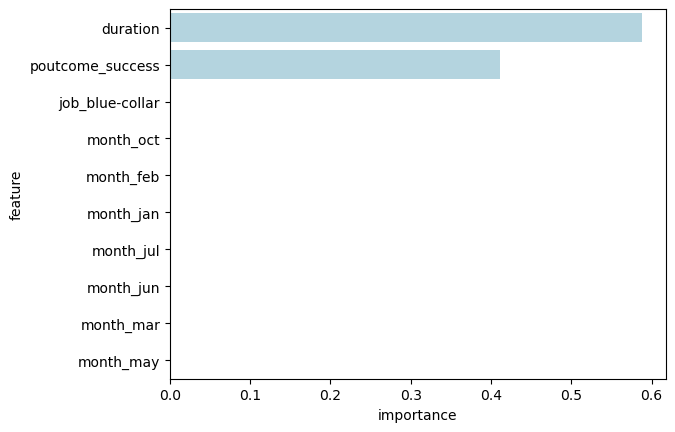

In [27]:
df_var_imp = pd.DataFrame({"feature": X_train_featurized.columns, 
                           "importance": dtree.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue");
plt.show()

Even though we didn't plot it, when we use decision trees to train a model, the trained model is (you guessed it!) a tree! This means that to get a prediction for any new data, we start at the top of the tree (called the **root**) and based on the data values we ultimately finish in one of the **leaves** of the tree, at which point we predict whatever the prediction is at the leaf we ended in.

## k-nearest neighbor classifier

A model trained using the k-nearest neighbor algorithm on the other hand is very different. It doesn't have a tree structure. Instead it labels a new data point by averaging the labels of the $k$ points nearest to it. For a numeric target, averaging can be done using the mean function. For categorical target, averaging means some sort of majority vote.

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knnb = KNeighborsClassifier(n_neighbors = 5)
knnb.fit(X_train_featurized, y_train)

y_hat_train = knnb.predict(X_train_featurized)
y_hat_test = knnb.predict(X_test_featurized)

Let's evaluate the model:

In [29]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

guessAccuracy = np.sum(y_test == 'yes')/y_test.shape[0]
print("Accuracy baseline on the test data: {:.0f}%.".format(100*max(guessAccuracy, 1.0-guessAccuracy)))

Accuracy on the training data: 92%.
Accuracy on the test data: 90%.
Accuracy baseline on the test data: 90%.


### Exercise (5 minutes)

- The `KNeighborsClassifier` classifier has a hyper-parameter called `n_neighbors`.  Are you more likely to overfit if you choose a smaller value or a larger one?
- The `KNeighborsClassifier` classifier has another hyper-parameter called `weights`. [Read up](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) on what this hyper-parameter does and change its value to something other than the default value. How does this affect your results?
- Instead of calling the `predict` method to get predictions, in the cell below call the `predict_proba` method and examine the results. How do the results returned by the `predict` and `predict_proba` methods relate to each other? HINT: It's not enough to examine the results by just looking at them, so see if you can use `np.argmax` to give a defininitive answer.

Most `sklearn` classifications have a method called `predict_proba`. Calling `predict` returns what we call **hard predictions** and calling `predict_proba` returns **soft predictions**.

### End of exercise

## Logistic regression classifier

The decision tree and k-nn algorithms could be used for both classification and regression, with some slight modifications. The logistic regression algorithm is another popular algorithm, but it is only used for classification. Careful here: even though it has the word **regression** in it, logistic regression is a **classification** algorithm, not a **regression** algorithm. A model trained using logistic regression predicts new classes using an **equation**. This makes logistic regression very efficient. In fact, once you have your trained model, you can pull out the equation's **coefficients** and implement it even in SQL: in just one query, although if we have a lot of features it could be long query!

In [17]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Let's evaluate the model:

In [18]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

guessAccuracy = np.sum(y_test == 'yes')/y_test.shape[0]
print("Accuracy baseline on the test data: {:.0f}%.".format(100*max(guessAccuracy, 1.0-guessAccuracy)))

Accuracy on the training data: 90%.
Accuracy on the test data: 90%.
Accuracy baseline on the test data: 90%.


So what does trained model's equation look like. To get the acutal equation we need to do some string processing with Python. Of course to get the predictions, we don't need to manually create the equation: we just need to call the `predict` method. But if we insisted on seeing the equation, we can run the next cell. 

**Note:** this equation gives what is called the **log-odds ratio**, and with an additional transformation that we skipped here, we can get the probability $P(Y_i = 1)$ from the log-odds ratio.

In [19]:
print('coefficients:\n', logit.coef_[0])
print('variables:\n', X_train_featurized.columns)

coefficients:
 [-0.64615258 -0.91568585 -1.08478851 -0.44528513  0.36779993 -0.37738718
 -0.11169276  0.66298827 -0.66539355 -0.0893065   0.05814002 -0.1223699
  0.14604983 -0.06950044  0.36356527  0.39412054 -0.10950747 -0.61551821
 -0.33379025  0.14520635 -1.41383064 -0.34900868  0.31684755 -0.35743211
 -1.5901374  -0.76348149  0.285525    1.89390852 -0.44782783 -0.74369222
 -0.12303363  0.36452451  0.44116536  2.03603963 -0.24457345 -0.16237185
  0.01785348 -0.04594201  1.0385938  -0.26887277 -0.06767376  0.03939256]
variables:
 Index(['job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb

We can combine these variable names and coefficients into a human-readable formula

In [20]:
variables = list(X_train_featurized.columns)
coefficients = map(str, list(logit.coef_[0]))
intercept = logit.intercept_[0]
var_coef_pairs = list(zip(variables, coefficients))
equation = str(intercept) + " + \n" + " + \n".join([v + " * " + c for v,c in var_coef_pairs])
print(equation)

-1.296484951696206 + 
job_blue-collar * -0.646152578425396 + 
job_entrepreneur * -0.9156858522206806 + 
job_housemaid * -1.0847885107456228 + 
job_management * -0.4452851294783383 + 
job_retired * 0.36779993304065894 + 
job_self-employed * -0.3773871818228463 + 
job_services * -0.1116927578533914 + 
job_student * 0.6629882709223401 + 
job_technician * -0.665393551194908 + 
job_unemployed * -0.08930650465519904 + 
job_unknown * 0.058140019307048395 + 
marital_married * -0.12236990271045854 + 
marital_single * 0.14604983182693165 + 
education_secondary * -0.06950043783631814 + 
education_tertiary * 0.363565269984842 + 
education_unknown * 0.394120538314214 + 
default_yes * -0.10950746864112526 + 
housing_yes * -0.6155182108150696 + 
loan_yes * -0.33379024702658305 + 
contact_telephone * 0.14520635032426135 + 
contact_unknown * -1.4138306368663531 + 
month_aug * -0.34900867990129697 + 
month_dec * 0.31684754946433785 + 
month_feb * -0.3574321114590435 + 
month_jan * -1.590137398548513 + 


Note that the absolute value of the **coefficients** in the above equation can be thought of as a measure of importance of its corresponding feature, similar to the **feature importance** metric we saw with decision trees. However, this is only true if the features are normalized! 

<hr style="border:10px solid gray">
<hr style="border:10px solid yellow">
<hr style="border:10px solid gray">

## Linear regression regressor

So far we've only seen classification algorithms. So it's time to change course and take a look at regression algorithms. For that we need to find a numeric target. We can use the `duration` column in the data as our target.

In [21]:
y_train = X_train_featurized['duration']
X_train_featurized = X_train_featurized.drop(columns = 'duration')

y_test = X_test_featurized['duration']
X_test_featurized = X_test_featurized.drop(columns = 'duration')

Other than changing the target from categorical to numeric, we don't have to do things very differently from before. The training and predicting part of the code remain very similar. 

In [22]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_featurized, y_train)

y_hat_train = linreg.predict(X_train_featurized)
y_hat_test = linreg.predict(X_test_featurized)

One difference from calssifications is that regressions are evaluated using different metrics. We used **accuracy** for the classification algorithms we saw above. We use **MSE** or **RMSE** for the regressions we train below. We can also choose other metrics as long as they're relevant to regression.

### Mean Squared Error (MSE)

$$\text{MSE} = \frac{1}{n}\sum_{i}(e_i)^2$$
where
$e_i$ is the error of the $i$th sample.  Generally, $e_i = y_i - \hat{y}_i$

MSE is used as a metric for how much the prediction varies from the actual numbers.  This variation is called variance and is a measure for a model's uncertainty or inaccuracy.

#### Total Sum of Squares
Total sum of squares ($SS_{tot}$) is calculated by summing up the squares of differences of the actual target values to the mean target value ($\bar{y}$).  This MSE would be for a regression model where we predict the average for all target values.  We consider this model to be our baseline.
$$SS_{tot} = \frac{1}{n}\sum_{i}(y_i - \bar{y})^2$$
where:  
$n$ is the number of samples
$y_i$ is the target value of the $i$th sample 
$\bar{y} = \frac{1}{n}\sum_{i}(y_i)$

#### Sum of Squares of Residuals
Sum of squares of residuals ($SS_{res}$) is calculated by summing up the squares of difference of the actual values to the predicted values.  Of course, we expect the sum of squares of residuals to be less than the total sum of squares.  Otherwise our model would be worse than doing nothing.
$$SS_{res} = \frac{1}{n}\sum_{i}(y_i - \hat{y}_i)^2$$

#### Compare Mean Squared Errors
We would like a metric that we can use to compare accuracies of regression models, even if the models are unrelated.  One way to use the $SS_{res}$ would be to scale $SS_{res}$ by its baseline, $SS_{tot}$:
$$\frac{SS_{res}}{SS_{tot}}$$
This scaled sum of residuals is 0 for the best models and 1 for models that are no better than guessing the average.  

#### Coefficient of Determination
Instead of the scaled sum of residuals, we would like a metric that had a scae similar to that of accuracy measures for classifications.  We would like this metric to be 1 for a perfect model and to be 0 for our baseline model.  We can create a metric like this by subtracting the scaled sum of residuals from 1.  We call this useful metric **Coefficient of Determination** ($R^2$).  
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Unfortunately, the symbol for **Coefficient of Determination** is $R^2$, even though it is not a squared entity and $R^2$ can be less than zero.  To make matters worse, $R^2$ is called r-squared and it is often confused with the square of Pearson's correlation coefficient.  Because of these confusions many data scientists do not know that they can use the **Coefficient of Determination** as an accuracy measure for regressions.  

In [23]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print("MSE on the training data: {:5.5f}.".format(mse_train))
print("MSE on the test data: {:5.5f}.".format(mse_test))

MSE on the training data: 0.97202.
MSE on the test data: 1.24016.


We don't know is this MSE is good or bad.  We need to compare it to the baseline MSE.  We could have used the coefficient of determination instead.

### Exercise (5 minutes)

To get MSE (mean squared error), here's what we need to do:

- find the **errors** (difference between predicted and actual value) and square them to get **squared errors**
- add up all the squared errors to get the **sum of squared errors**
- divide the sum of squared errors by the number of rows to get the **mean squared error**

- Use the training data to calculate the MSE using `numpy` and compare it to what you get when you run `mean_squared_error`. If you use `numpy` correctly, you should not have to write any loops.

In [24]:
def MSE(y_test, y_hat_test = None):
    if y_hat_test is None:
        y_hat_test = y_test.mean()
    Error = y_test - y_hat_test
    SquaredError = Error**2
    MeanSquaredError = SquaredError.mean()
    return MeanSquaredError

print("Training MSE:", MSE(y_train, y_hat_train))
print("Test MSE:", MSE(y_test, y_hat_test))
print("Baseline MSE:", MSE(y_test))

Training MSE: 0.9720151539447085
Test MSE: 1.2401582172761305
Baseline MSE: 1.253089007142539


The difference in MSE isn't enough.  It seems that this model isn't very good either.  
Note that the RMSE stands for **root mean squared error**, which is the square root of the MSE.
### End of exercise

### Plot the Results (Sanity Check)
Another very important test is to plot your predicted results from your test data against the known results of your test data.

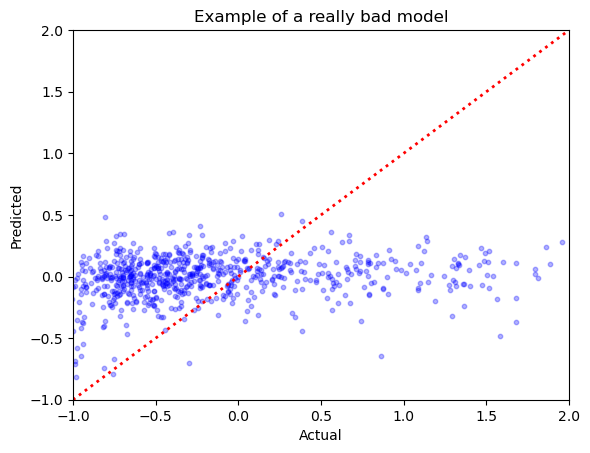

In [25]:
plottingData = pd.DataFrame({'y_test':y_test, 'y_hat_test':y_hat_test}).sort_values(by='y_test')

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot([-1, 2], [-1, 2], c='red', lw=2, ls=':')
plt.scatter(plottingData['y_test'], plottingData['y_hat_test'], s=10, c='blue', alpha = 0.3)
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.title('Example of a really bad model')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

### Neural Net (Optional)

The next algorithm we're going to try is a neural network. Neural networks are considered complex algorithms, which means that 
- (1) they will consume a lot of compute, 
- (2) it's very easy to overfit with them, and
- (3) they are not a good option if we care about explainability. 

Neural networks take the data and compute their own features, and they compute an increasingly complex set of features because they are composed of layers. The features created in earlier layers affect the ones in later layers, allowing for increased complexity. In a way, you can say neural networks do their own feature engineering and are really good at it. This is one of their greatest strength, but it also means they are very data hungry. 

There is no free lunch in data science and machine learning. The neural network we're going to use here will only have a few **hidden layers**, and the number of hidden neurons in each layer is a hyperparameter that can be specified. Neural networks with lots of hidden layers take us into the topic of **deep learning** and instead of `sklearn` we would need to start using libraries like `tensorflow` or `pytorch` (they are also called **frameworks**) on top of GPU machines to be able to handle the computational workload.

In [26]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes = [25, 16, 14, 12], early_stopping = False, max_iter = 2000)
nn.fit(X_train_featurized, y_train)

y_hat_train = nn.predict(X_train_featurized)
y_hat_test = nn.predict(X_test_featurized)

In [27]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print("MSE on the training data: {:5.5f}.".format(mse_train))
print("MSE on the test data: {:5.5f}.".format(mse_test))

MSE on the training data: 0.37719.
MSE on the test data: 1.93140.


Neural networks can capture very complex relationships, but they can overfit very easily. Tuning the hyper-parameters of a neural network is not an easy task. Hyper-parameters like number of hidden layers and number of hidden neurons per layer affect the neural network's **architecture**.